## Initialisation time series

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings
import struct
import binascii

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

python 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
keras version 2.6.0
tensorflow version 2.6.0


In [ ]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([])
	inp = keras.layers.Input(batch_shape= (batch_size, X.shape[1], X.shape[2]),name="input")
	rnn = keras.layers.LSTM(neurons, stateful=False,name="RNN")(inp)
	dens = keras.layers.Dense(1,name="dense")(rnn)#keras.layers.TimeDistributed(keras.layers.Dense(1,name="dense"))(rnn)
	model = keras.models.Model(inputs=[inp],outputs=[dens])
	model.compile(loss="mean_squared_error",
                  optimizer="adam")
	model.summary()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


## Evaluation

Fonction de détermination de l'erreur absolue en pourcentage

Combien de \% d'écart en moyenne entre la donnée prédite et la donnée mesurée

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

## Importation des données

Colonnes importées : 2e, 3e et 8e colonnes

2e colonne : Temps
3e colonne : identifiant Antenne
7e colonne : Quantité de données

In [ ]:
dataframe = read_csv('/dataset.csv', usecols=[1,2,7], engine='python')

In [ ]:
dataset = dataframe.values

In [ ]:
dataset = dataset.astype('float32')
where_are_NaNs = np.isnan(dataset)
dataset[where_are_NaNs] = 0

## Sélection des données

Isolation d'une antenne (ID : 39)

Convertion du temps en heures

In [ ]:
newdataset1 = []
newdataset2 = []

for i in range(len(dataset)):
    if dataset[i,1]==39:
        a = dataset[i, 2]
        b = (dataset[i, 0]-1383260400000)/3600000
        newdataset1.append(a)
        newdataset2.append(b)

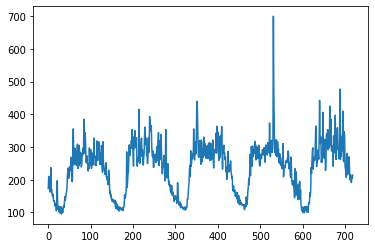

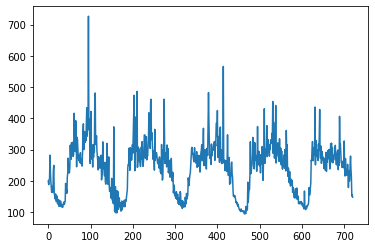

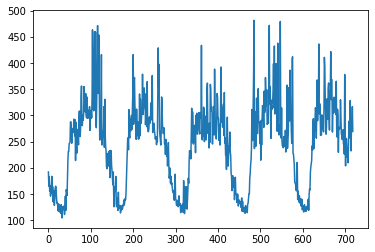

In [ ]:
raw_values = np.asarray(newdataset1)
l=len(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):-int(l/3)])
plt.show()
plt.plot(raw_values[-int(l/3):])
plt.show()

## Découpage du jeu de données

Définition d'un jeu d'entrainement et d'un jeu de test

Mise à l'échelle des données sur l'intervalle \[0,1\]

[-363.16381836 -363.16381836]
[373.3527832 373.3527832]


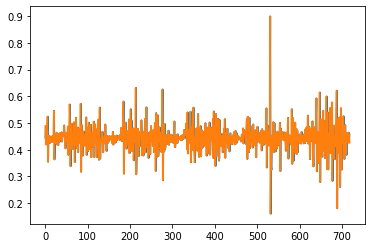

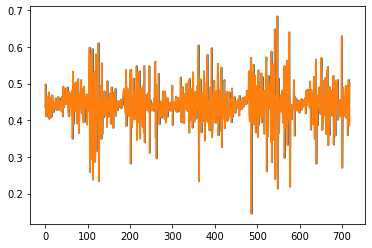

In [ ]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(l/3)])
plt.show()
plt.plot(test_scaled[:int(l/3)])
plt.show()

In [ ]:
test_scaled[0]

raw_values[-int(l/3)-0]

191.95605

## Entrainement

In [ ]:
hunits = 150

lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

(1439, 1, 1)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(1, 1, 1)]               0         
_________________________________________________________________
RNN (LSTM)                   (1, 150)                  91200     
_________________________________________________________________
dense (Dense)                (1, 1)                    151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


array([[0.43824217],
       [0.4349587 ],
       [0.43999007],
       ...,
       [0.4402583 ],
       [0.44356418],
       [0.4379658 ]], dtype=float32)

## Prédiction

Prédiction de la donnée et établissement d'un jeu de données prédite.

In [ ]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	expected = raw_values[len(train) + i + 1]

	predictions.append(yhat)

for i in range(len(test_scaled)):
	print('hour=%d, Predicted=%f, Expected=%f' % ((i+1)/6, predictions[i], raw_values[len(train) + i + 1]))

hour=0, Predicted=146.197829, Expected=191.956055
hour=0, Predicted=194.255743, Expected=164.897003
hour=0, Predicted=161.770041, Expected=182.858307
hour=0, Predicted=183.278620, Expected=155.276047
hour=0, Predicted=152.105307, Expected=165.862061
hour=1, Predicted=165.730578, Expected=145.821472
hour=1, Predicted=143.276110, Expected=163.629761
hour=1, Predicted=164.038782, Expected=157.103607
hour=1, Predicted=155.648082, Expected=183.635971
hour=1, Predicted=184.683540, Expected=150.563354
hour=1, Predicted=146.929472, Expected=164.106354
hour=2, Predicted=164.197419, Expected=134.988403
hour=2, Predicted=131.688769, Expected=141.608185
hour=2, Predicted=141.175281, Expected=156.797821
hour=2, Predicted=157.012098, Expected=128.033493
hour=2, Predicted=124.763588, Expected=139.992706
hour=2, Predicted=139.964827, Expected=159.881165
hour=3, Predicted=160.443811, Expected=164.712021
hour=3, Predicted=164.142101, Expected=162.614120
hour=3, Predicted=161.507160, Expected=144.544479


Generate proper data with 1 data shift

In [ ]:
# walk-forward validation on the training data
X_train = list()
y_train = list()

X_train.append(train_scaled[len(train_scaled)-1, 0:-1][0])
y_train.append(train_scaled[0, 0:-1][0])

for i in range(1,len(train_scaled)):
	# make one-step forecast
    X_train.append(train_scaled[i-1, 0:-1][0])
    y_train.append(train_scaled[i, 0:-1][0])
    
for i in range(len(train_scaled)):
	print('X_train=%f, y_train=%f' % (X_train[i], y_train[i]))

X_train=0.447637, y_train=0.443775
X_train=0.443775, y_train=0.489216
X_train=0.489216, y_train=0.419188
X_train=0.419188, y_train=0.433686
X_train=0.433686, y_train=0.419556
X_train=0.419556, y_train=0.454473
X_train=0.454473, y_train=0.524359
X_train=0.524359, y_train=0.354362
X_train=0.354362, y_train=0.452008
X_train=0.452008, y_train=0.424531
X_train=0.424531, y_train=0.437975
X_train=0.437975, y_train=0.451010
X_train=0.451010, y_train=0.425360
X_train=0.425360, y_train=0.434361
X_train=0.434361, y_train=0.446799
X_train=0.446799, y_train=0.438043
X_train=0.438043, y_train=0.429177
X_train=0.429177, y_train=0.451676
X_train=0.451676, y_train=0.430366
X_train=0.430366, y_train=0.432408
X_train=0.432408, y_train=0.453686
X_train=0.453686, y_train=0.546044
X_train=0.546044, y_train=0.363016
X_train=0.363016, y_train=0.417084
X_train=0.417084, y_train=0.454731
X_train=0.454731, y_train=0.424067
X_train=0.424067, y_train=0.442697
X_train=0.442697, y_train=0.464402
X_train=0.464402, y_

In [ ]:
# walk-forward validation on the testing data
X_test = list()
y_test = list()

X_test.append(test_scaled[len(test_scaled)-1, 0:-1][0])
y_test.append(test_scaled[0, 0:-1][0])

for i in range(1,len(test_scaled)):
	# make one-step forecast
    X_test.append(test_scaled[i-1, 0:-1][0])
    y_test.append(test_scaled[i, 0:-1][0])
    
for i in range(len(test_scaled)):
	print('X_test=%f, y_test=%f' % (X_test[i], y_test[i]))

X_test=0.502387, y_test=0.435522
X_test=0.435522, y_test=0.497889
X_test=0.497889, y_test=0.410709
X_test=0.410709, y_test=0.465723
X_test=0.465723, y_test=0.410070
X_test=0.410070, y_test=0.456710
X_test=0.456710, y_test=0.419286
X_test=0.419286, y_test=0.465536
X_test=0.465536, y_test=0.435800
X_test=0.435800, y_test=0.476196
X_test=0.476196, y_test=0.403361
X_test=0.403361, y_test=0.460324
X_test=0.460324, y_test=0.408193
X_test=0.408193, y_test=0.451864
X_test=0.451864, y_test=0.462336
X_test=0.462336, y_test=0.408626
X_test=0.408626, y_test=0.458388
X_test=0.458388, y_test=0.468078
X_test=0.468078, y_test=0.449678
X_test=0.449678, y_test=0.441211
X_test=0.441211, y_test=0.421694
X_test=0.421694, y_test=0.429245
X_test=0.429245, y_test=0.444961
X_test=0.444961, y_test=0.433267
X_test=0.433267, y_test=0.434761
X_test=0.434761, y_test=0.460047
X_test=0.460047, y_test=0.441348
X_test=0.441348, y_test=0.427690
X_test=0.427690, y_test=0.455646
X_test=0.455646, y_test=0.439447
X_test=0.4

## LSTM model

Our goal is to create a LSTM model to predict y_train using the time series X_train

In [ ]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
model1 = lstm_model
model1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(1, 1, 1)]               0         
_________________________________________________________________
RNN (LSTM)                   (1, 150)                  91200     
_________________________________________________________________
dense (Dense)                (1, 1)                    151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
w = np.zeros(y_train_array.shape[:2])
D=1
w[D:] = 1 
w_train = w

from keras.callbacks import ModelCheckpoint
start = time.time()
hist1 = model1.fit(X_train_array, y_train_array, 
                   batch_size=1,
                   epochs=50, 
                   verbose=False,
                   validation_split=0.5,
                   shuffle=False)
end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))

labels = ["loss","val_loss"]
for lab in labels:
    plt.plot(hist1.history[lab],label=lab + " model1")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
for layer in model1.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
warr,uarr, barr = weightLSTM
print(warr)
print("\n")
print(uarr)
print("\n")
print(barr)

print(model1.layers[2].get_weights())
warr.shape,uarr.shape,barr.shape

[[ 2.62251012e-02  3.12222410e-02 -2.86302697e-02 -1.30694821e-01
   1.09349256e-02 -1.60058327e-02 -4.69512418e-02 -2.14105975e-02
   5.85847870e-02 -9.80644301e-02  2.32287467e-01  1.48148825e-02
   3.23735505e-01 -9.26228166e-02  4.30162586e-02  5.41108772e-02
  -8.79867375e-02 -8.75324979e-02  1.55562870e-02  6.15357570e-02
  -5.31219542e-02  1.81669500e-02 -8.53567123e-02  5.33854403e-03
  -9.86082107e-02  3.51197203e-03  4.73524556e-02 -1.03065319e-01
   6.50939941e-02  1.15625776e-01  1.70699842e-02  4.12960798e-02
  -1.28569007e-01  6.92149028e-02  1.09285461e-02 -5.81028014e-02
   2.48446129e-02 -2.92288922e-02 -1.39588844e-02 -9.09753516e-02
  -2.61793863e-02  1.98030248e-02 -1.33421496e-01  6.76029474e-02
  -5.29839359e-02  3.87367606e-02 -3.18993889e-02 -1.26297578e-01
  -3.77020538e-02  6.75166547e-02  2.40715057e-01 -1.11905634e-01
  -3.87168080e-02 -1.31161824e-01  4.11684141e-02 -1.02366835e-01
   3.94556411e-02 -8.54351297e-02 -1.15176134e-01 -2.73163728e-02
  -1.10106

((1, 600), (150, 600), (600,))

In [ ]:
def sigmoid(x):
    return(1.0/(1.0+np.exp(-x)))
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    warr,uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    hunit = uarr.shape[0]
    i  = sigmoid(s_t[:,:hunit])
    f  = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o  = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

In [ ]:
c_tm1 = np.array([0]*hunits).reshape(1,hunits)
h_tm1 = np.array([0]*hunits).reshape(1,hunits)

In [ ]:
xs  = X_train_array
for i in range(len(xs)):
    x_t = xs[i].reshape(1,1)
    h_tm1,c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
print("h3={}".format(h_tm1))
print("c3={}".format(c_tm1))

h3=[[-1.86511857e-04 -7.43942188e-02 -1.01777993e-01  5.25529055e-02
  -5.70273895e-02  4.41634822e-02  1.37721307e-01  1.35772992e-01
  -3.73309241e-02  1.27979007e-01 -2.28011592e-02 -4.71673714e-02
  -1.25946256e-01 -7.16505134e-02 -3.10503274e-02 -6.09363799e-02
  -1.27018744e-01 -4.23985767e-02 -4.94893113e-02  2.24018492e-02
  -5.41548150e-02 -1.15296763e-01 -1.37448455e-01 -2.03750092e-02
   7.10862718e-02 -8.14868753e-02 -1.79281743e-02 -1.38851609e-01
  -7.32203997e-02  2.76319806e-02 -6.88400966e-02  4.17347789e-02
   8.56427240e-02 -1.94343478e-02 -4.26585763e-02 -1.06379396e-01
  -2.89428589e-02 -5.99678623e-02  1.79438337e-01  7.08788631e-02
  -6.70556833e-02  9.60799190e-02  1.02391786e-01 -1.54050894e-01
  -3.35904473e-02  4.60911523e-02  7.64137607e-03 -6.07894906e-02
  -4.87395121e-02  1.68906605e-01  8.14653985e-03  1.29544303e-01
   1.24268139e-02  1.65085247e-01  6.14606521e-02  8.19849689e-02
  -4.90346176e-02 -7.00499181e-02  9.04308103e-02 -4.19891848e-02
  -8.02

In [ ]:
xs

array([0.44763699, 0.4437747 , 0.48921583, ..., 0.39184112, 0.41538961,
       0.36800379])

batch_size = 1
len_ts = len(xs)
nfeature = 1

inp = keras.layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  
rnn,s,c = keras.layers.LSTM(hunits, 
                         return_sequences=True,
                         stateful=False,
                         return_state=True,
                         name="RNN")(inp)
states = keras.models.Model(inputs=[inp],outputs=[s,c, rnn])

for layer in states.layers:
    for layer1 in model1.layers:
        if layer.name == layer1.name:
            layer.set_weights(layer1.get_weights())
            
h_t_keras, c_t_keras, rnn = states.predict(xs.reshape(1,len_ts,1))
print("h3={}".format(h_t_keras))
print("c3={}".format(c_t_keras))

In [ ]:
model1.layers[2].get_weights()[0]

array([[ 0.10572137],
       [ 0.4486746 ],
       [-0.22848843],
       [-0.39934912],
       [-0.26273555],
       [-0.19199073],
       [ 0.15822992],
       [-0.24519974],
       [ 0.18533789],
       [-0.26270026],
       [ 0.13747217],
       [ 0.38513306],
       [ 0.34858853],
       [-0.25029057],
       [-0.12389065],
       [-0.14762451],
       [-0.20476736],
       [-0.3614929 ],
       [-0.21579278],
       [-0.19235815],
       [-0.20964262],
       [-0.20118506],
       [-0.20938753],
       [ 0.33464855],
       [ 0.29338267],
       [-0.33403957],
       [ 0.14250988],
       [-0.20275179],
       [-0.3115227 ],
       [ 0.18366632],
       [-0.35316718],
       [-0.15209693],
       [-0.2052368 ],
       [-0.12947737],
       [ 0.35385537],
       [ 0.11870625],
       [-0.3480861 ],
       [-0.32921496],
       [ 0.15901479],
       [-0.3761773 ],
       [ 0.3394533 ],
       [ 0.40093789],
       [ 0.2538861 ],
       [-0.142739  ],
       [-0.30557466],
       [-0

In [ ]:
#test de la quantization en 16 (les fonctions sont définies en bas de la page)
n = '00111111011111110001000100111101'

print(n[:16])
bin_to_float(n[:16]+'0000000000000000')

quantization16([ 0.735573,  0.9963568, 0.28433755, -1.1191157 ])

In [ ]:
quantizationInverse16([14818, 15352, 13452, 48249])

In [ ]:
lstm_model.layers[0]

In [ ]:
file_object =  open('/parameters.h', 'w')

In [ ]:
file_object.write("//\n// Generated by spiderweak using Python.\n//\n\n#ifndef CPP_PARAMETERS_H\n#define CPP_PARAMETERS_H\n\n")

99

In [ ]:
file_object.write("#define HUNIT " + str(hunits) + "\n\n")

19

In [ ]:
file_object.write("#endif //CPP_PARAMETERS_H\n\nconst int hunit = HUNIT;\n\nconst float lstm_cell_input_weights[4 * HUNIT] = {")

103

In [ ]:
model1.layers[1].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float lstm_cell_hidden_weights[4 * HUNIT * HUNIT] = {")

63

In [ ]:
model1.layers[1].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float lstm_cell_bias[4 * HUNIT] = {")

45

In [ ]:
model1.layers[1].get_weights()[2].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nstatic float lstm_cell_hidden_layer[HUNIT] = {")

50

In [ ]:
h_tm1.tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\nstatic float lstm_cell_cell_states[HUNIT] = {")

48

In [ ]:
c_tm1.tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float dense_weights[HUNIT] = {")

40

In [ ]:
model1.layers[2].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\nconst float dense_bias = ")

28

In [ ]:
model1.layers[2].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write(";\n")

2

In [ ]:
file_object.close()

In [ ]:


fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,2,1)
ax.plot(h_tm1.flatten(),h_t_keras.flatten(),"p")
ax.set_xlabel("h by hand")
ax.set_ylabel("h by Keras")

ax = fig.add_subplot(1,2,2)
ax.plot(c_tm1.flatten(),c_t_keras.flatten(),"p")
ax.set_xlabel("c by hand")
ax.set_ylabel("c by Keras")
plt.show()

In [ ]:
def quantization8(weight):
    return int(wMin + weight/255 * (wMax - wMin))

def quantizationInverse8(weight8):
    return 

In [ ]:
def float_to_bin(num):
    return bin(struct.unpack('!I', struct.pack('!f', num))[0])[2:].zfill(32)

def bin_to_float(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

def quantization16(weights32):
    weights16 = []
    for weight in weights32:
        weights16.append(bin_to_float(float_to_bin(weight)[:16] + '0000000000000000'))
    return weights16
